## Model Training

### 1.1 Import Data and Required Packages

In [1]:
pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.7 MB/s eta 0:00:00


In [2]:
pip install opendatasets --quiet

In [3]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

### Import the CSV Data as Pandas DataFrame

In [4]:
df = pd.read_csv('/content/StudentsPerformance.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
df['total_score'] = df['math_score'] + df['reading_score'] + df['writing_score']
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229


## Preparing X and Y variables

In [6]:
X = df.drop(columns=['total_score'],axis=1)
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [8]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in 'parental_level_of_education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test_preparation_course:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in 'parental_level_of_education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test_preparation_course:      ['none' 'completed']


In [9]:
y = df['total_score']

#### Create Column Transformer with 3 types of transformers

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
 8   total_score                  1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [11]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [12]:
X = preprocessor.fit_transform(X)

In [13]:
X.shape

(1000, 20)

### Train and Test Dataset Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 20), (200, 20))

### Create an Evaluate Function to give all metrics after model Training

In [16]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

#### Model Training

In [18]:
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000


Lasso
Model performance for Training set
- Root Mean Squared Error: 1.0644
- Mean Absolute Error: 0.8505
- R2 Score: 0.9994
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.1139
- Mean Absolute Error: 0.8764
- R2 Score: 0.9994


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.0241
- Mean Absolute Error: 0.0195
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0264
- Mean Absolute Error: 0.0201
- R2 Score: 1.0000


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 6.7719
- Mean Absolute Error: 5.3040
- R2 Score: 0.9745
-----------------------

### Result

In [19]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,1.000000
2,Ridge,1.000000
1,Lasso,0.999357
6,XGBRegressor,0.996425
5,Random Forest Regressor,0.993683
7,CatBoosting Regressor,0.993457
4,Decision Tree,0.987993
8,AdaBoost Regressor,0.978733
3,K-Neighbors Regressor,0.956016


#### Linear Regression

In [20]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 100.00


### Plot y_pred and y_test

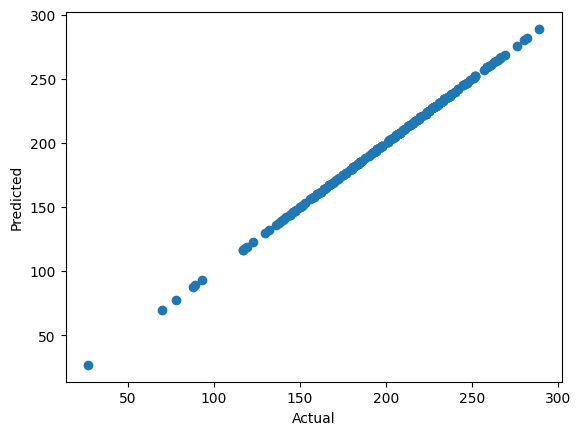

In [21]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

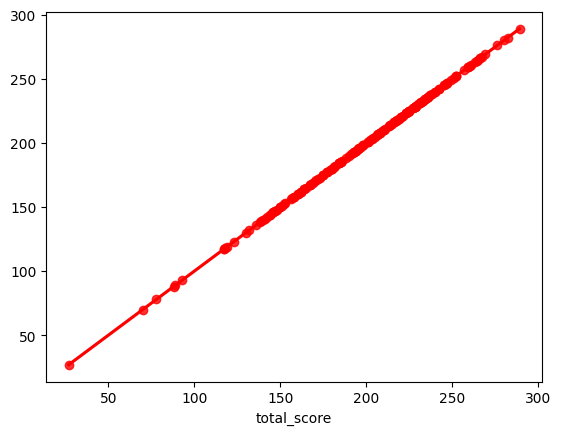

In [22]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

### Difference between Actual and Predicted Values

In [23]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,261,261.0,0.000000e+00
737,192,192.0,0.000000e+00
740,225,225.0,2.842171e-14
660,224,224.0,0.000000e+00
411,245,245.0,2.842171e-14
...,...,...,...
408,165,165.0,0.000000e+00
332,171,171.0,0.000000e+00
208,231,231.0,2.842171e-14
613,216,216.0,0.000000e+00
